# The Edwards Aquifer and Bexar county: Looking to the Future

### The **WHY** of this project
As climate change increasingly affects how our planet, societies and economies function, water scarcity will hit everyone hard. Texas is no exception. The Texas Water Development Board estimates that at current trends "approximately 26 percent (13.3 million) of all Texans in 2070 would have less than half of the municipal water supplies they require." Further, without addressing these concerns "the estimated statewide impacts of not meeting the identified water needs in Texas would result in an annual combined lost income of \\$110 billion in 2020, increasing to \\$153 billion by 2070." See chapter 6 in the [link](https://www.twdb.texas.gov/waterplanning/swp/2022/docs/SWP22-Water-For-Texas.pdf) for more info.

It's imperative that we discover the causes, drivers, and various factors that play into available water. By truly understanding these now, we can properly implement mitigation strategies and prevention efforts before the situation becomes any more drastic than it already is.

This project is very limited in scope in that it attempts to understand a small slice of the picture in Texas. I have analyzed the historical water levels of Bexar county's J17 Index Well. The J17 gives a good snapshot of the day-to-day situation of the Edwards Aquifer as it pertains to available water for San Antonio and Bexar county at large. See [link](https://www.edwardsaquifer.net/j17.html) for more info. 

Ultimately, the goal is to predict future water levels through Time Series Analysis, but I've also explored relationships between historical water levels and other historical data (population, temperature, precipitation, water consumption) in an attempt to discover ways to better understand what may contribute to the Edwards Aquifer rise and fall. Pulling those variables in to make a more complex multivariate time series model would yield better predictions but it's beyond the scope of the current project.

# Overall Project Plan
## Goals
- Gain an understanding of historic water usage for Bexar county and what factors may affect rises or falls in the Edwards Aquifer water level.
    - Explore relationships between historic water level, water usage, population, precipitation, and temperature data for Bexar county.
- Perform a Time Series Analysis of the water level elevation for the Edwards Aquifer J17 Index Well.
    - Construct a resulting univariate time series model that accurately predicts water levels for J17 Index Well.
- Make relevant suggestions for future water supply conservation strategies.
---
## Data Science Pipeline

- [**Acquire**](#Data-Acquisition) data from various sources:
    - Edwards Aquifer J17 Index Well Historical Data from: https://www.edwardsaquifer.org/science-maps/aquifer-data/historical-data/
    - Bexar County population data from US census data: https://worldpopulationreview.com/us-counties/tx/bexar-county-population
    - Historical Water Use estimates from Texas Water Development Board: https://www.twdb.texas.gov/waterplanning/waterusesurvey/estimates/index.asp
    - Bexar County historical climate data (temp and precipitation) from: https://usafacts.org/issues/climate/state/texas/county/bexar-county
    - Initial inquiry into the data to see the initial shape and layout.
- Clean and [**prepare**](#Data-Preparation) data for the explore phase. Create wrangle.py to store functions I create to automate the full process of acquisition, cleaning and preparation. Separate train, validate, test subsets.
- Begin [**exploration**](#Data-Exploration) of the data and ask questions leading to clarity of what is happening in the data.
    - Determine if any relationships exist that might explain historical water level elevation changes.
        - Find interactions between independent variables and the target variable using visualization and statistical testing.
    - Discover any trends and or seasonality in the target variable data.
- Create baseline [**models**](#Modeling) based on averages and then create more detailed predictive models. Compare performance and select best model.
    - Evaluate models on train and validate datasets. Do further hyperparamter tuning to find the best performing models.
    - Choose the model with that performs the best. Do any final tweaking of the model. Automate modeling functions and put them into a model.py file.
- Evaluate final model on the test dataset.
---
## Deliverables
- A Final Report Notebook wherein I show how I arrived at the MVP model. Throughout the notebook, document conclusions, takeaways, and next steps.
    - Include [**Conclusions, recomendations, next steps**](#Conclusions,-Recommendations,-Next-Steps)
- A github repo containing my final report
- A README.md file containing a data dictionary, project and business goals, initial hypothesis and an executive summary for my github repo
- Project summary and writeup for my resume or other professional portfolio pieces

# Executive Summary
- My best performing model, Facebook Prophet beat the baseline when predicting on out-of-sample data.
- Water level elevation as a target is highly variable, borderline random. This makes accurate predictions nearly impossible for univariate time series models.
- I found during Exploration that several of the datapoints I collected correlate to the target variable. 
    - Variables that I have shown to be statistically correlated with the target variable are **total water consumption and precipitation amounts**. Using these in a multivariate model could increase chances for better predictions, but In order to use these in a such a model it would require additonal work not done in the current project.

**Recommendations**
- Despite beating baseline, I don't feel confident in this model. I would **not suggest** it be used going forward as it seems likely that it was random chance that the model beat baseline in this instance.
- Explore other reasons why the change in month-to-month water levels has grown increasingly variable over time post 1957/58.

In [1]:
# import data manipulation libraries
import pandas as pd
import numpy as np

# import data visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns
import pylab

# import modeling and stats libraries
import scipy.stats as stats
import statsmodels.api as sm
from statsmodels.tsa.api import Holt
from sklearn.metrics import mean_squared_error
from prophet import Prophet

# import personal script files to automate work
import wrangle
import explore
import model

# Setting parameters
import warnings
warnings.filterwarnings("ignore")
plt.rcParams["figure.figsize"] = (16, 10)

# Data Acquisition and Preparation
I gathered requisite datasets from various sources online (see overall project plan above) and downloaded them to .csv files.

In [2]:
# Using a function to access data stored locally to pull in all data into dataframes.
aquifer, temps, precip, pop, usage = wrangle.get_dataframes()

In [3]:
# Cleaning the dataframes
aquifer, weather, pop, usage = wrangle.clean_all_dataframes(aquifer, temps, precip, pop, usage)

The following was done to prepare the data:
- Unwanted columns were dropped
- All columns renamed to snake_case appropriate names
- All dataframes set to datetime index and index was sorted by date
- A composite dataframe consisting of temps and precip was made and named weather
- Nulls were sparse and in irrelevant columns and thusly dropped.

In [4]:
#Verifying data
aquifer.info(), weather.info(), pop.info(), usage.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 31919 entries, 1932-11-12 to 2022-06-12
Data columns (total 1 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   water_level_elevation  31919 non-null  float64
dtypes: float64(1)
memory usage: 498.7 KB
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1529 entries, 1895-01-01 to 2022-05-01
Data columns (total 2 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   avg_monthly_temp      1529 non-null   float64
 1   total_monthly_precip  1529 non-null   float64
dtypes: float64(2)
memory usage: 35.8 KB
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 38 entries, 1850-01-01 to 2022-01-01
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   population  38 non-null     int64
dtypes: int64(1)
memory usage: 608.0 bytes
<class 'pandas.core.frame.

(None, None, None, None)

The target variable dataframe aquifer has no nulls and is 31919 entries. No nulls present in any other dataframe.

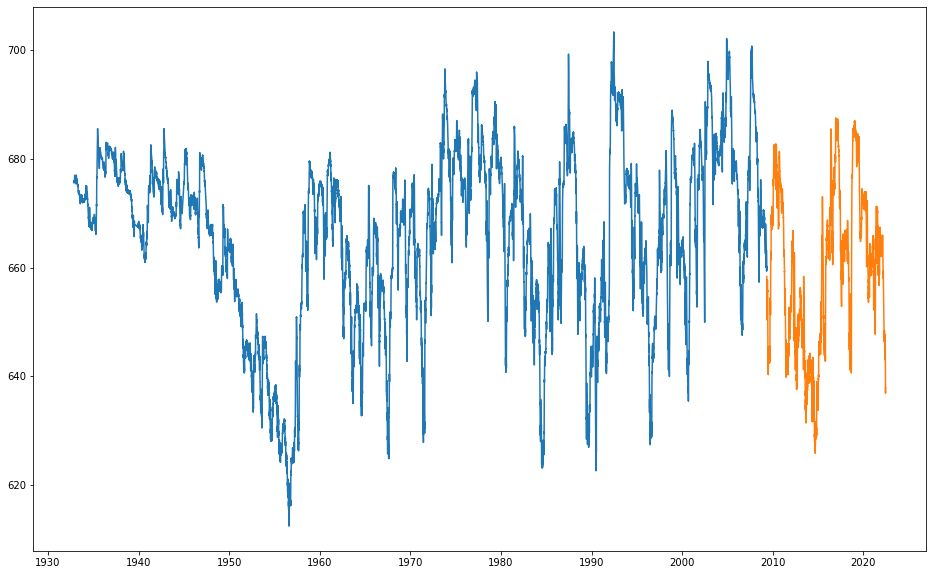

In [5]:
# Splitting for exploration with accompanying visual to show the split.
train, test = explore.train_test_split(aquifer)

# Exploration
I will start by investigating the target variable alone as that is what will be used for modeling, after which I will explore it with the other variables to better understand the target data.

Thoughts before exploring:
- Looking at the graph above of the target variable, it looks like there may be some predictable yearly variation patterns, but over all there doesn't seem to be seasonal patterns of larger than one year that would explain the peaks and drops in the water level.
- Intuitively, I think population will affect water level as increased population will increase water usage and therefore decrease the water level.
- I also think precipitation amounts and water usage amounts will affect the water level. 
- It seems logical that precipitation, water usage, population, and water level would all be correlated but I can't say what is a causal relationship.

### Visualizing Distribution

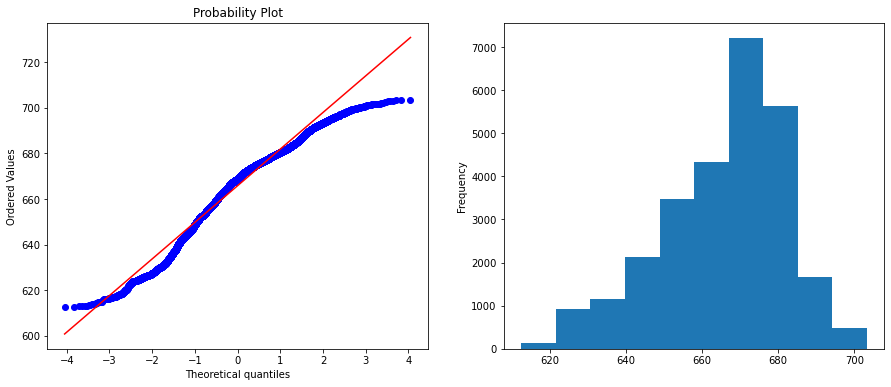

In [6]:
# QQ (Quantile-Quantile Plot) to show how well the data approximates a normal distribution as well as a histogram
explore.distribution_graphs(train)

Between the two graphs above we can see that the train data shows a decently normal distribution with a slight left skew.


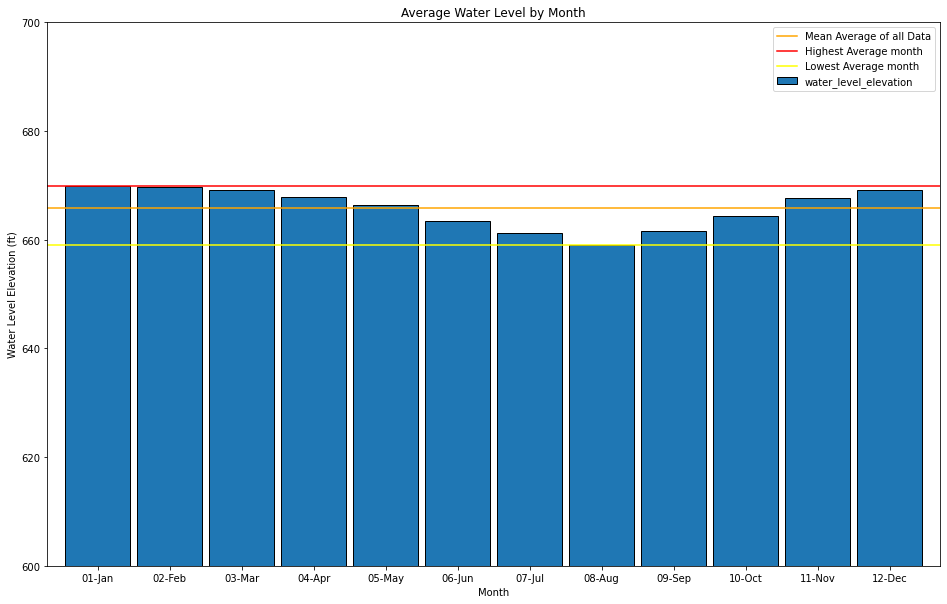

In [7]:
# Exploring the average water level separated by month to see if there are any differences that might show up seasonally.
explore.monthly_distribution(train)

There is a slight water level dip around the summer months which I've exaggerated some by setting the y-value of the graph to start at 600 to show the difference more clearly. This may become more apparent when looking at seasonality later.

The difference between the highest and lowest month means is about 10 feet.

### Visualizing the change over time

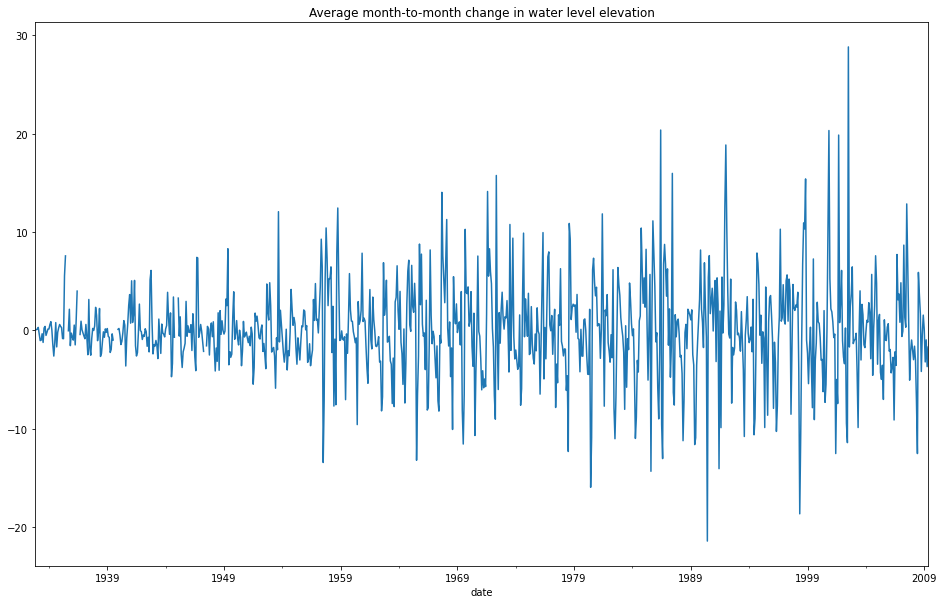

In [8]:
# Exploring the change over time when looking at month to month averages
explore.change_by_month(train)

Here I notice some heteroskedasticity. The monthly change over time seems to exhibite higher variability as time has gone on. Specifically it looks like things got way more variable around 1957/58.


### Seasonal Plots
Seasonal plots can show if there is any repeated pattern year over year.

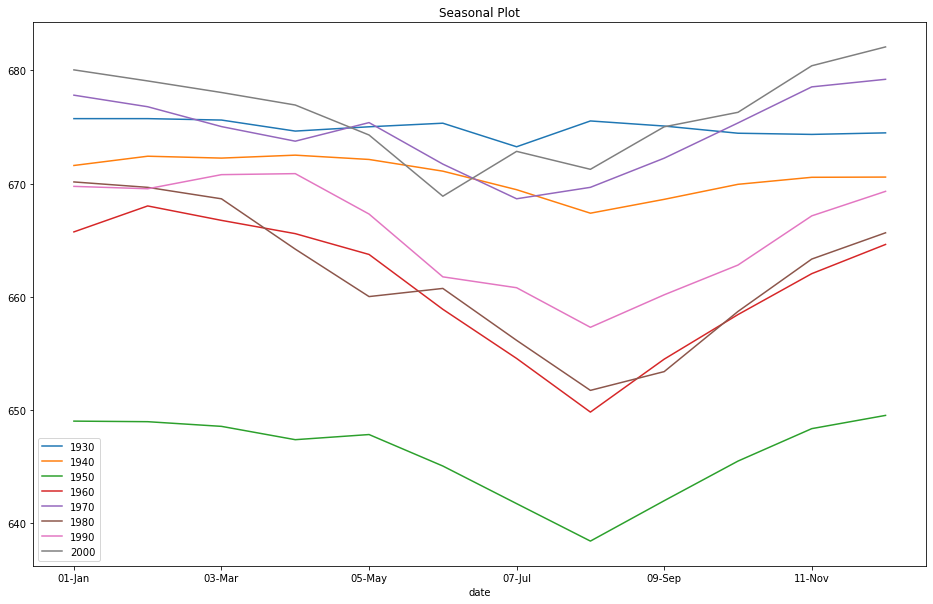

In [9]:
# Checking for annual seasonality when observing by the decade. I originally showed every year individually and it was 
# overwhelming. Grouping by averages of each decade makes for a much more deciperable graph. 
explore.annual_seasonality(train)

When grouping by the decade, the graph indicates that there is a general dip in water level elevation during the summer months.

### Lag plots
Lag plots allow us to see the differences between one day and following day separated by a given amount of time. It can show if there is an underlying patternt to the data not as easily detected in other ways.

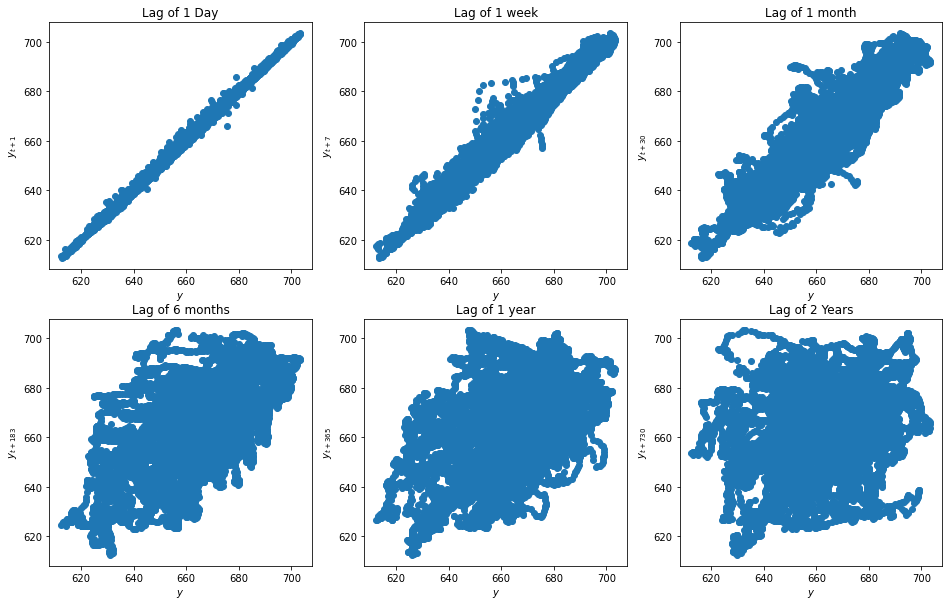

In [10]:
# Setting up multiple lag plots to show how the lag shows increases with successively larger intervals.
explore.lag_plots(train)

#### Takeaways from lag plot
- From day to day and week to week there is very little daily or weekly change in aquifer levels.
- The water level when it does change seems to do so gradually over time rather than drastic 1 day or 1 week or even 1 month changes even.
- Major differences don't show up until looking beyond 6 months.

### Seasonal Decomposition

This will help us discover overall trends and seasonal patterns apparent in the data.

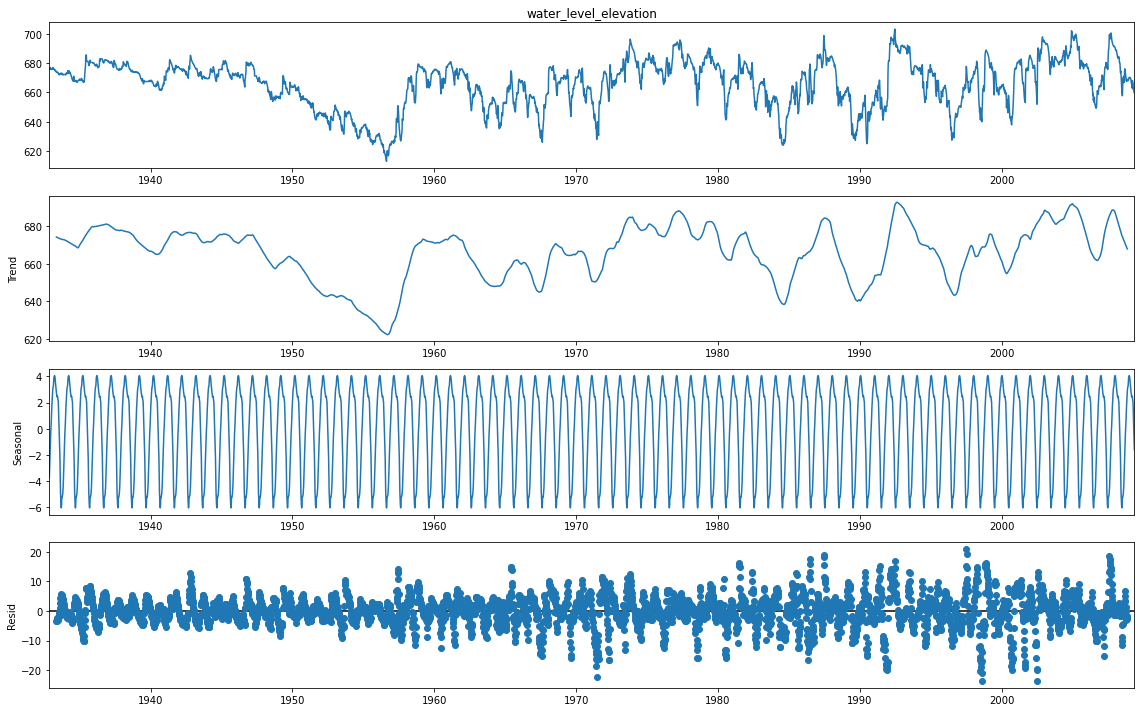

In [11]:
# Running a seasonal decomposition on the target variable and displaying the original, trend, seasonal and residual graphs from 
# the decomposition.
explore.seasonal_decomposition_graphs(train)

From this graph it looks as though the "Trend" accounts for most of the variation seen.
- The seasonal effects seem to show highs in the winter months with swings the lowest months in the summer months being a yearly pattern without fail. This matches well with the mean highs and lows seen previously.

### Bivariate comparisons
Even though I won't be doing multivariate time series modeling I want to do some hypothesis testing with the other data I pulled in to see if I can better understand the target.

I have a few hypotheses I want to test, the first of which is the relationship of precipitation to the target variable aquifer water level elevation. Intuition tells me that more precipitation should implicate more water in the aquifer, thus increasing the water level elevation.

#### Correlation Testing
##### Hypothesis 1
alpha = .05

$H_{0}$ = There is no linear correlation between aquifer water level elevation and precipitation when observing at the monthly level.

$H_{a}$ = There is a linear correlation between aquifer water level elevation and precipitation when observing at the monthly level.


The pearson r test shows a result of 4.883984648557827e-05 and an r value of 0.13412634812059762.
See graph below.


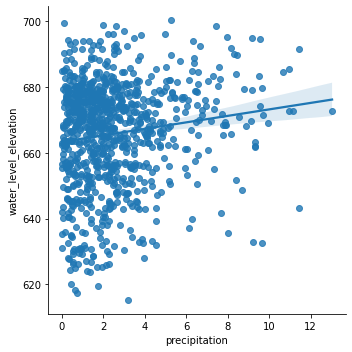

In [12]:
# Setting alpha
alpha = .05

# Running a pearson-r correlation test, printing the results as well as a visualization.
explore.precip_elevation_monthly_corr_test(train, weather)

Since p < alpha, I can reject the null and accept that there is a positive correlation between water level elevation and precipitation but it's not very strong at just .134.

I want to investigate the data resampled to a larger time like yearly to see if the correlation is different. There may be a lag between time of precipitation and resulting water level elevation change. Resampling to means of larger times will better account for this.

##### Hypothesis 2
alpha = .05

$H_{0}$ = There is no linear correlation between aquifer water level elevation and precipitation when observing at the annual level.

$H_{a}$ = There is a linear correlation between aquifer water level elevation and precipitation when observing at the annual level.


The pearson r test shows a result of 0.0003669216475456505 and an r value of 0.393365789907362.
See graph below.


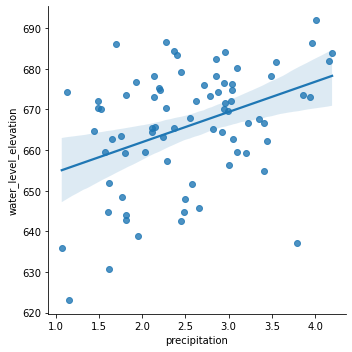

In [13]:
# Running a pearson-r correlation test, printing the results as well as a visualization.
explore.precip_elevation_yearly_corr_test(train, weather)

Since p < alpha, I reject the null and accept that there is a positive correlation between water level elevation and precipitation when viewed at an annual level. The relationship is .393 which is stronger than when observing at the monthly level. This suggests there is a linkage between water level elevation and precipitation but itmay be delayed due to time it takes for water to affect the aquifer.

Upon reflection it may also be that water consumption decreases slightly after precipitation due to people not needing to pull water for tasks the rain took care of, eg. watering plants/lawns, irrigation, etc.  So I now want to look at the link between precipitation and water consumption.

##### Hypothesis 3
alpha = .05

$H_{0}$ = There is no linear correlation between total water consumption and precipitation when observing at the annual level.

$H_{a}$ = There is a linear correlation between total water consumption and precipitation when observing at the annual level.


The pearson r test shows a result of 9.592127558045673e-08 and an r value of -0.8373827539505966.
See graph below.


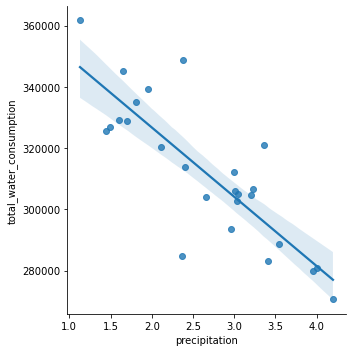

In [14]:
# Running a pearson-r correlation test, printing the results as well as a visualization.
explore.precip_usage_yearly_corr_test(train, weather, usage)

I reject the null and observe a strong negative relationship in precipitation and water consumption when observing at the annual level. What this means is that as precipitation increases, overall water usage decreases. The statistically significant r value here is -.837.

I need to investigate whether or not water consumption is correlated to aquifer water level elevation (the target variable).

##### Hypothesis 4
alpha = .05

$H_{0}$ = There is no linear correlation between total water consumption and water_level_elevation when observing at the annual level.

$H_{a}$ = There is a linear correlation between total water consumption and water_level_elevation when observing at the annual level.


The pearson r test shows a result of 0.025424580422415372 and an r value of -0.43745866213221885.
See graph below.


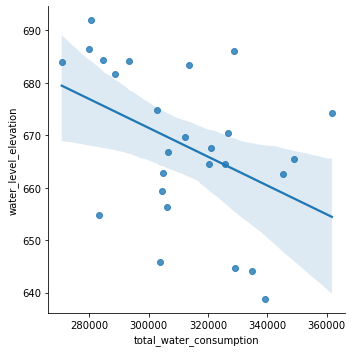

In [15]:
# Running a pearson-r correlation test, printing the results as well as a visualization.
explore.usage_elevation_yearly_corr_test(train, usage)

I reject the null and observe a moderately strong negative relationship of -.437 in total_water_consumption and water_level_elevation when observing at the annual level. As total water consumption increases, there is a decrease is water level elevation.

Finally, I need to check for a statisically significant relationship between population and total water consumption.

##### Hypothesis 5
alpha = .05

$H_{0}$ = There is no linear correlation between water_level_elevation and population when observing at the annual level.

$H_{a}$ = There is a linear correlation between water_level_elevation and population when observing at the annual level.


The pearson r test shows a result of 0.2600964163183689 and an r value of 0.1290624506870609.
See graph below.


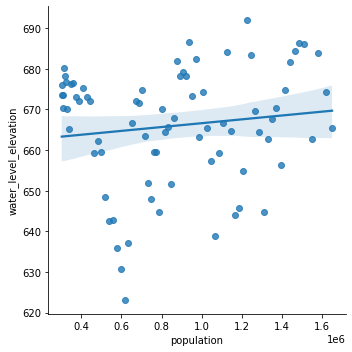

In [16]:
# Running a pearson-r correlation test, printing the results as well as a visualization.
explore.pop_elevation_yearly_corr_test(train, pop)

I fail to reject the null hypothesis, the current data indicate there is no linear correlation between water level elevation and population.



## EDA Takeaways

- Target Variable Aquifer water level:
    - The annual seasonality shows a roughly 9 foot swing from the highest point in the winter months to the lowest point in the summer months. 
    - The "trend" tends to look more like random noise than showing an up or down trend.
    - The daily, weekly and monthly variations (see lag plots) tend to be quite small. Meaning the water level for today is quite predictive for the next day, the next week and the next month. Beyond this it spreads out considerably. Changes in water level elevation seem to be small changes added over time; this can result in bigger differences over larger time spans.
    
- Target Variable with other variables:
    - There is a positive correlation between water level elevation and precipitation when viewed at an annual level with an r of .393. To me this indicates there is a linkage but the effects of increased precipitation may be delayed due to the time it takes for water to fill up the aquifer.
    - I find that there is a quite strong negative relationship in precipitation and water consumption when observing at the annual level.  What this means is that as precipitation increases, overall water usage decreases. The statistically significant r value here is -.863.
    - I also found that there is a moderately strong negative relationship of -.678 in total_water_consumption and water_level_elevation when observing at the annual level. As total water consumption increases, there is a decrease is water level elevation.
    - Strangle, the current data do not support a linear relationshiop between water level elevation and population.
    - **Main Takeaway from this**: As it rains the water level rises for at least two reasons:
    1) Less water is consumed when it rains
    2) Water is replenished into the aquifer

# Modeling

Before jumping into modeling, I need to reset the train, validate, test split and setup a dataframe for storing RMSE results.

The lengths of train, validate, test match the total length of the dataframe. Ready for modeling.


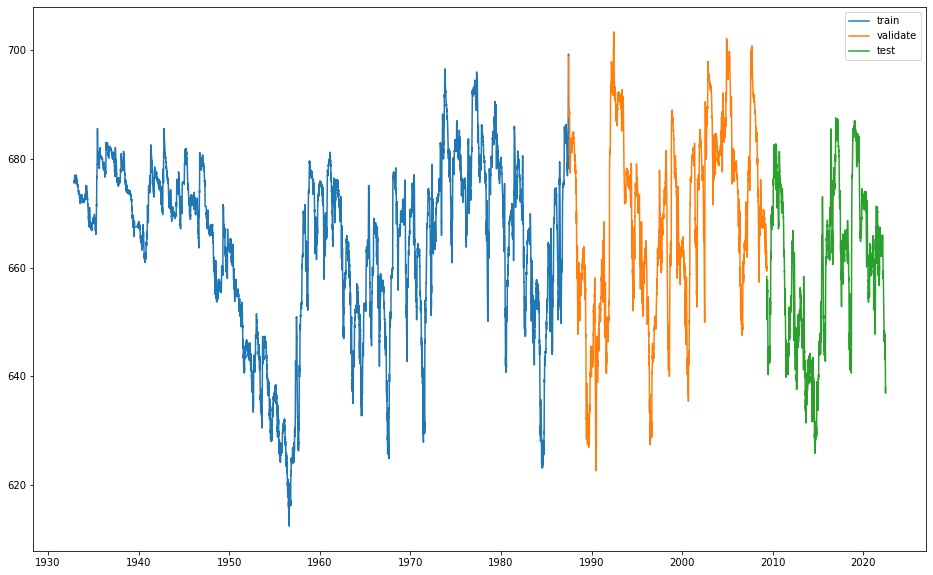

In [17]:
# Creating an empty_df to store the model RMSE results
eval_df = pd.DataFrame(columns=['model_type', 'target_var', 'rmse'])

# The splits before were for EDA alone, now splitting for modeling.
train, validate, test = model.splits(aquifer)

### Creating models and predicting

For modeling I will start with some basic predictions in order to acquire a baseline.
1. Last Observed Value: This will predict that future values will look like the most recent value.
2. Simple Average: This will predict that future values will look like a historical average. 
3. Moving Average: This will predict that future values will look like a recent period of time's average. 

Then I will move into more advanced predictive models: 

4. Holt's Linear Trend
5. Previous Cycle
6. Facebook Prophet


### Baseline models
#### Last observed value

The simplest method for forecasting is to predict all future values to be the last observed value.  

Predicting for the last_observed_value model -- RMSE: 34.0


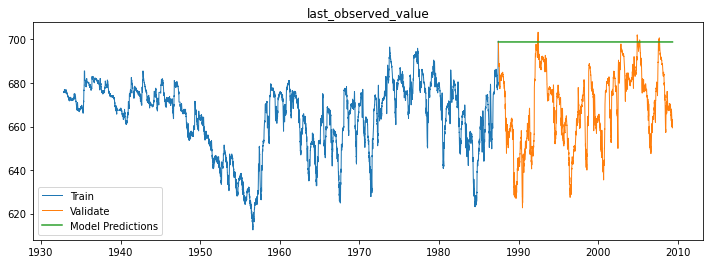

In [18]:
# Using the last observed value to make and plot out predictions against actual validate values. Then storing 
# the RMSE results in eval_df for comparison with other models later.
eval_df = model.lov_model(train, validate, eval_df)

#### Simple Average

This takes the historical average and uses that to predict future values.   

This is a possible good option for an initial baseline.

Predicting for the simple_avg model -- RMSE: 18.0


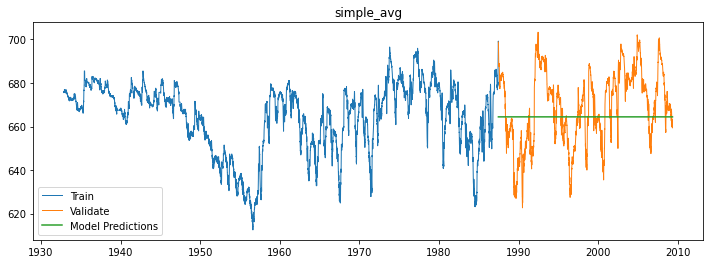

In [19]:
# Using the simple average to make and plot out predictions against actual validate values. Then storing 
# the RMSE results in eval_df for comparison with other models later.
eval_df = model.simple_avg_model(train, validate, eval_df)

#### Moving Average

I will use a range of different rolling averages to see which works the best.


Predicting the 7 day Moving Average of 698.88 -- RMSE: 34.0

Predicting the 14 day Moving Average of 696.7 -- RMSE: 32.0

Predicting the 30 day Moving Average of 689.45 -- RMSE: 26.0

Predicting the 60 day Moving Average of 683.93 -- RMSE: 22.0

Predicting the 365 day Moving Average of 675.25 -- RMSE: 18.0

Predicting the 730 day Moving Average of 669.34 -- RMSE: 17.0

Predicting the 1825 day Moving Average of 658.43 -- RMSE: 20.0

Predicting the 3650 day Moving Average of 666.32 -- RMSE: 17.0


Plot of the best Moving Average model
Predicting for the 730_day_moving_avg model -- RMSE: 17.0


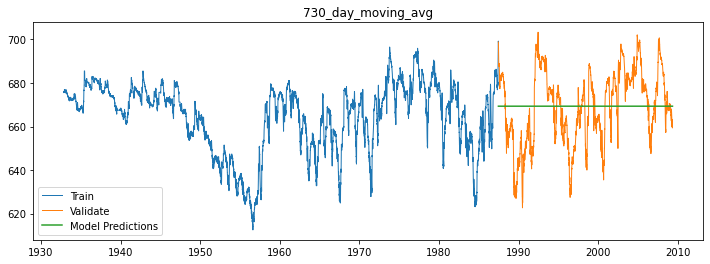

In [20]:
# Using a moving (rolling) of 7, 14, 30, 60, 365, 730, 1825, 3650 day periods to make predictions against actual validate values.
# Printing out the prediction, and RMSE for each period and then plotting out the best performing model.
eval_df = model.moving_average_model(train, validate, eval_df)

The best performing model so far is the 730 day (2 year) moving avg with an RMSE of 17. Going forward the 730_day_moving_avg will be my baseline with RMSE of 17.

### More advanced models
#### Holt's Linear Trend

Predicting for the holts_optimized model -- RMSE: 33.0


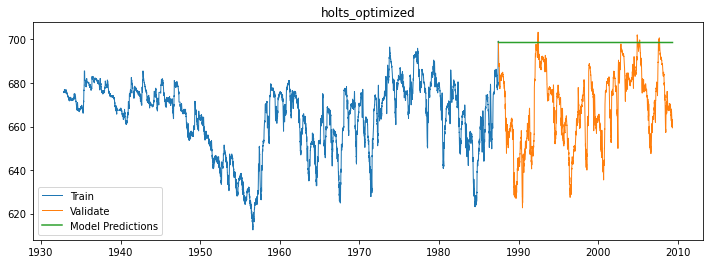

In [21]:
# Using the Holt's Linear Trend model to make and plot out predictions against actual validate values. Then storing 
# the RMSE results in eval_df for comparison with other models later.
eval_df = model.holts_model(train, validate, eval_df)

Holt's linear trend model performed terribly. Since there is no identifiable previous cycle, I can't use this method to predict future values.

I will need to find a better model if I am going to beat baseline, but it's entirely possible there is no model that will accurately predict this based on water level elevation data alone since it's seemingly random. Thus univariate time series forecasts would not be possible. Taking into account other variable data would be valuable but as it stands this is beyond the scope of this project.

### Facebook Prophet
Facebook prophet is a more advanced model so I am hoping it will provide better results.

Because Prophet requires specific columns I need to prepare the data first before using the model.

In [22]:
# Creating a new dataframe to use for the prophet model and showing the shape of the new dataframe.
train_for_prophet = model.prophet_setup(train)

14:28:13 - cmdstanpy - INFO - Chain [1] start processing
14:28:21 - cmdstanpy - INFO - Chain [1] done processing


Predicting for the facebook_prophet model -- RMSE: 46.0


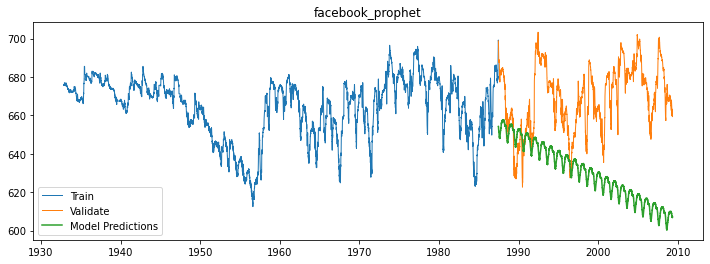

In [23]:
# Using the Facebook Prophet model to make and plot out predictions against actual validate values. Then storing 
# the RMSE results in eval_df for comparison with other models later.
eval_df = model.prophet_model(train, validate, train_for_prophet, eval_df)

### Facebook Prophet tweaked
The initial Prophet model at default settings performed the worst yet, but I optimized some setting to get the following model.

14:28:30 - cmdstanpy - INFO - Chain [1] start processing
14:28:30 - cmdstanpy - INFO - Chain [1] done processing


Predicting for the modified_facebook_prophet model -- RMSE: 17.0


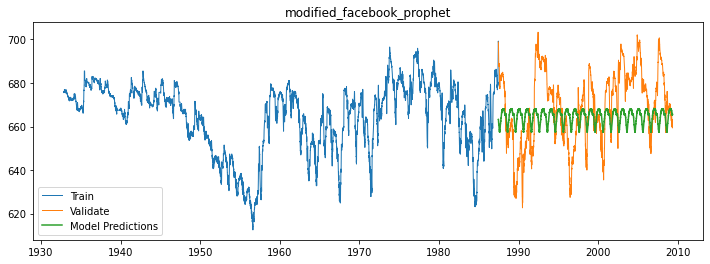

In [24]:
# Creating and showing the results/plot of the better performing Facebook Prophet model
eval_df = model.modified_prophet_model(train, validate, train_for_prophet, eval_df)

In [25]:
# Showing the RMSE results of all the models.
eval_df.sort_values('rmse')

,model_type,target_var,rmse
7,730_day_moving_avg,water_level_elevation,17.0
9,3650_day_moving_avg,water_level_elevation,17.0
12,modified_facebook_prophet,water_level_elevation,17.0
1,simple_avg,water_level_elevation,18.0
6,365_day_moving_avg,water_level_elevation,18.0
8,1825_day_moving_avg,water_level_elevation,20.0
5,60_day_moving_avg,water_level_elevation,22.0
4,30_day_moving_avg,water_level_elevation,26.0
3,14_day_moving_avg,water_level_elevation,32.0
10,holts_optimized,water_level_elevation,33.0


## Takeaways before testing on out of sample data

- The best performing model was a tie between the modified facebook prophet model and the baseline 730_day_moving_avg which both return an RMSE of 17.
- The target variable data seems to be too random to accurately predict univariately.
- I will select the Facebook Prophet model as my final model going forward to have something to compare to the baseline 730_day_moving_avg when testing on out of sample data.

## Model testing

14:29:02 - cmdstanpy - INFO - Chain [1] start processing
14:29:02 - cmdstanpy - INFO - Chain [1] done processing


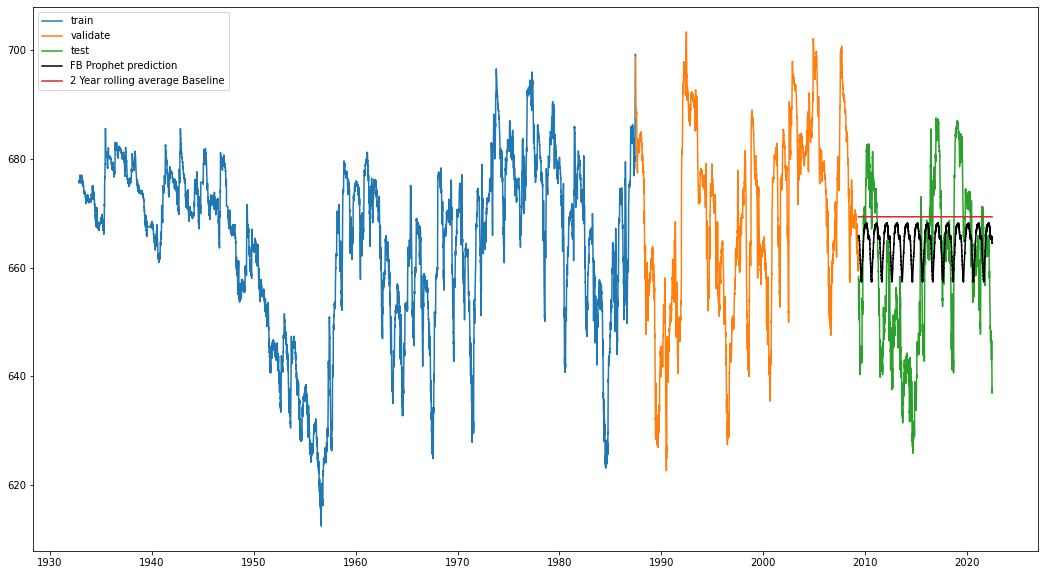

The RMSE for the FB prophet model on out-of-sample test data is:14.67.
The RMSE for the two year moving avg baseline on out-of-sample test data is:17.29.


In [27]:
# Testing the facebook prophet model on out of sample test data, visualizing the predictions and printing RMSE results.
model.mod_prophet_testing(train, validate, test, train_for_prophet)

### Modeling Final Takeaways

- The best performing model, Facebook Prophet gave a resulting RMSE of 14.67 feet when predicting on out-of-sample data. This beats the baseline two year moving average which had an RMSE of 17.29 feet when predicting on out-of-sample data.
    - I would not suggest this model be used going forward as it appears random chance is responsible for beating baseline.
- The Edwards Aquifer water level elevation measurements may be closer to a Random Walk than any discernable pattern. "A random walk is one in which future steps or directions cannot be predicted on the basis of past history." (Page 26, A Random Walk down Wall Street: The Time-tested Strategy for Successful Investing). Other variables must play into the water level elevation that would allow for better prediction.
    - Variables that I think would affect the target variable and have shown to be statistically correlated with the target variable are **total water consumption and precipitation amounts**.
    - I also suspect total population would affect the target as total population implies increased consumption but I was not able to show this relationship exists to a statistically significant level from the data available to me.

# Conclusions, Recommendations, Next Steps
- My best performing model, Facebook Prophet beat the baseline when predicting on out-of-sample data.
- Water level elevation as a target is highly variable and may be closer to a Random Walk than any discernable pattern. This makes accurate predictions nearly impossible for univariate time series models.
- I found during Exploration that several of the datapoints I collected correlate to the target variable. 
    - Variables that I have shown to be statistically correlated with the target variable are **total water consumption and precipitation amounts**. Using these in a multivariate model could increase chances for better predictions, but In order to use these in a such a model it would require additonal work not done in the current project.

**Recommendations**
- Despite beating baseline, I don't feel confident in this model. I would **not suggest** it be used going forward as it seems likely that it was random chance that the model beat baseline in this instance.
- Explore other reasons why the change in month-to-month water levels has grown increasingly variable over time post 1957/58.

**Future work**
- I would need further time to continue working towards creating a multivariate time series model. The additional work would  be significant and would require more study to adequately implement. However, the payoff could be considerable as it might prove to more accurately predict the target variable.
- Further exploration of the data, finding additional correlating variables and discovering their trends and seasonality would be valuable in understanding any patterns in the target variable.